In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/labeled-data/test_augmented.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test2 = test

train_res = train["Survived"].reset_index(drop = True)

In [5]:
#Embarked
train['Embarked'] = train['Embarked'].fillna("S")

#Alone
train['T_partner']=train["SibSp"]+train["Parch"]
train['Alone']=np.where(train['T_partner']>0, 0, 1)
#FamilySize
# train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
# def map_family_size(size):
#     if size == 1:
#         return 'Alone'
#     elif 2 <= size <= 4:
#         return 'Small'
#     elif 5 <= size <= 6:
#         return 'Medium'
#     else:
#         return 'Large'
# train['FamilySizeGroup'] = train['FamilySize'].apply(map_family_size)
# fs = pd.get_dummies(train['FamilySizeGroup'], drop_first=True)
# train = pd.concat([train, fs], axis=1)
# train.drop(['FamilySizeGroup'], axis=1, inplace=True)

#Name Length 
train['Words_Count'] = train['Name'].apply(lambda x: len(x.split()))

# FamilyName
# train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
# train['Surname'] = train['Surname'].astype('category')
# train['Surname'] = train['Surname'].cat.codes
# train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
# train['FamilyID'] = train['Surname'] + '_' + train['FamilySize'].astype(str)
# family_id_counts_train = train['FamilyID'].value_counts()
# train['FamilyID_freq'] = train['FamilyID'].map(family_id_counts_train)
# train.drop(['Surname', 'FamilyID'], axis=1, inplace=True)

#Title
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['Title'] = train['Title'].map(title_mapping)
train['Title'] = train['Title'].fillna(0)

# Age (Title + Sex + Pclass | median)
train['Age'] = train['Age'].fillna(
    train.groupby(['Title', 'Sex', 'Pclass'])['Age'].transform('median')
)

#extract and map cabin number
train['Cabin'] = train['Cabin'].fillna('U')
import re
# Extract first letter
train['Cabin'] = train['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
# Mapping 'Cabin' to group
train['Cabin'] = train['Cabin'].map(cabin_category)

#convert nonnumerical data to numerical
g = pd.get_dummies(train['Sex'], drop_first = True)
e = pd.get_dummies(train['Embarked'], drop_first = True)
p = pd.get_dummies(train['Pclass'], drop_first = True)
train = pd.concat([g,train,e,p], axis =1)

#create minor column for age as minors have greatly increased chance of survival
# train['is_minor']=np.where(train['Age']<=16,1,0)

#clean tickets
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

#Pclass*Sex
train['Sex_Pclass'] = train['Sex'].astype(str) + '_' + train['Pclass'].astype(str)
sex_pclass_dummies = pd.get_dummies(train['Sex_Pclass'], prefix='SexPclass')
train = pd.concat([train, sex_pclass_dummies], axis=1)
train.drop(['Sex_Pclass'], axis=1, inplace=True)

#Binning
# train['AgeBin'] = pd.qcut(train['Age'], q=10, labels=False, duplicates='drop')
# train['FareBin'] = pd.qcut(train['Fare'], q=5, labels=False, duplicates='drop')
# train.drop(['Age', 'Fare'], axis=1, inplace=True)

#drop extra columns
train.drop('SibSp', axis=1, inplace=True)
train.drop('Parch', axis=1, inplace=True)
train.drop('T_partner', axis=1, inplace=True)
train.drop(["PassengerId", "Name", "Ticket",'Pclass','Sex','Embarked', "Survived"], axis = 1, inplace = True)

In [6]:
# Embarked
test['Embarked'] = test['Embarked'].fillna("S")
test["Fare"].fillna(14.45, inplace=True)

test['T_partner']=test["SibSp"]+test["Parch"]
test['Alone']=np.where(test['T_partner']>0, 0, 1)
# FamilySize
# test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
# def map_family_size(size):
#     if size == 1:
#         return 'Alone'
#     elif 2 <= size <= 4:
#         return 'Small'
#     elif 5 <= size <= 6:
#         return 'Medium'
#     else:
#         return 'Large'
# test['FamilySizeGroup'] = test['FamilySize'].apply(map_family_size)
# fs = pd.get_dummies(test['FamilySizeGroup'], drop_first=True)
# test = pd.concat([test, fs], axis=1)
# test.drop(['FamilySizeGroup'], axis=1, inplace=True)

# Name Length
test['Words_Count'] = test['Name'].apply(lambda x: len(x.split()))

#FamilyName
# test['Surname'] = test['Name'].apply(lambda x: x.split(',')[0])
# test['Surname'] = test['Name'].apply(lambda x: x.split(',')[0])
# test['Surname'] = test['Surname'].astype('category')
# test['Surname'] = test['Surname'].cat.codes
# test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
# test['FamilyID'] = test['Surname'] + '_' + test['FamilySize'].astype(str)
# family_id_counts_test = test['FamilyID'].value_counts()
# test['FamilyID_freq'] = test['FamilyID'].map(family_id_counts_test)
# test.drop(['Surname', 'FamilyID'], axis=1, inplace=True)

# Title
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
test['Title'] = test['Title'].map(title_mapping)
test['Title'] = test['Title'].fillna(0)

# Age (Title + Sex + Pclass | median)
test['Age'] = test['Age'].fillna(
    test.groupby(['Title', 'Sex', 'Pclass'])['Age'].transform('median')
)

# Cabin
test['Cabin'] = test['Cabin'].fillna('U')
import re
test['Cabin'] = test['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
test['Cabin'] = test['Cabin'].map(cabin_category)

# Categorical to numeric
g = pd.get_dummies(test['Sex'], drop_first=True)
e = pd.get_dummies(test['Embarked'], drop_first=True)
p = pd.get_dummies(test['Pclass'], drop_first=True)
test = pd.concat([g, test, e, p], axis=1)

# Minor
# test['is_minor'] = np.where(test['Age'] <= 16, 1, 0)
# test['FareBin'] = pd.qcut(test['Fare'], q=5, labels=False, duplicates='drop')

# Ticket_type
test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

#pclass*sex
test['Sex_Pclass'] = test['Sex'].astype(str) + '_' + test['Pclass'].astype(str)
sex_pclass_dummies = pd.get_dummies(test['Sex_Pclass'], prefix='SexPclass')
test = pd.concat([test, sex_pclass_dummies], axis=1)
test.drop(['Sex_Pclass'], axis=1, inplace=True)

# Drop unnecessary columns
test.drop('SibSp', axis=1, inplace=True)
test.drop('Parch', axis=1, inplace=True)
test.drop('T_partner', axis=1, inplace=True)
test.drop(["PassengerId", "Name", "Ticket", 'Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)

/tmp/ipykernel_36/2374391166.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["Fare"].fillna(14.45, inplace=True)


In [7]:
train.columns

Index([              'male',                'Age',               'Fare',
                    'Cabin',              'Alone',        'Words_Count',
                    'Title',                  'Q',                  'S',
                          2,                    3,        'Ticket_type',
       'SexPclass_female_1', 'SexPclass_female_2', 'SexPclass_female_3',
         'SexPclass_male_1',   'SexPclass_male_2',   'SexPclass_male_3'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split
test.columns = test.columns.astype(str)
train_x, val_x, train_y, val_y = train_test_split(train, train_res, random_state = 0)
train_x.columns = train_x.columns.astype(str)
val_x.columns = val_x.columns.astype(str)

submission csv created
Ensemble Survival Percentage: 33.25%


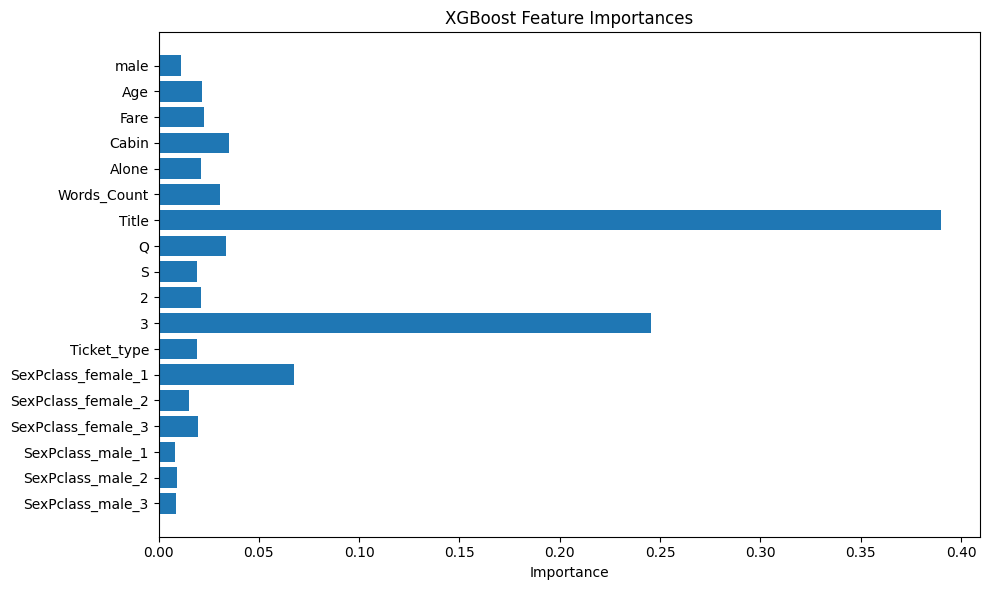

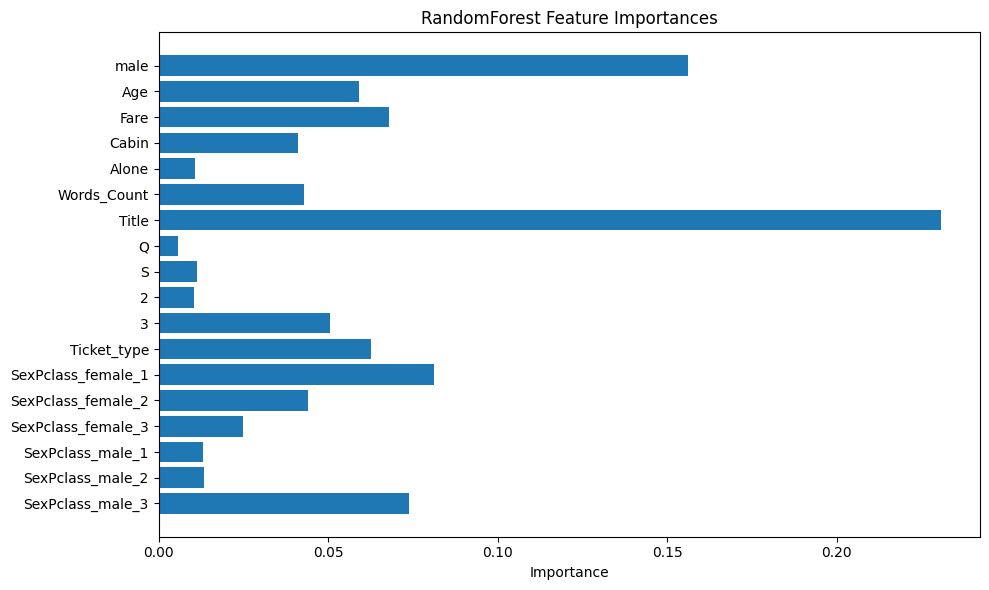

In [91]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Models
xgb1 = XGBClassifier(n_estimators=500, max_depth=5,random_state=777, use_label_encoder=False, eval_metric='logloss')
rf = RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=5, random_state=777)
lr = LogisticRegression(max_iter=1000, solver="liblinear", random_state=777)

#Voting Classifier
ensemble = VotingClassifier(
    estimators=[('xgb1', xgb1), ('rf', rf), ('lr', lr)],
    voting='hard',  # 확률 평균
)

ensemble.fit(train_x, train_y)
X_test = test[train_x.columns]
predictions = ensemble.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test2['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission_ensemble.csv', index=False)
print("submission csv created")

survival_percentage = (submission['Survived'].sum() / len(submission)) * 100
print(f"Ensemble Survival Percentage: {survival_percentage:.2f}%")

# 🎯 Feature Importance 시각화 - XGBoost
xgb_model = ensemble.named_estimators_['xgb1']
xgb_importance = xgb_model.feature_importances_
xgb_features = train_x.columns

plt.figure(figsize=(10, 6))
plt.barh(xgb_features, xgb_importance)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# 🎯 Feature Importance 시각화 - RandomForest
rf_model = ensemble.named_estimators_['rf']
rf_importance = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(train_x.columns, rf_importance)
plt.title("RandomForest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [92]:
import pandas as pd

df = pd.read_csv('/kaggle/input/labeled-data/test_augmented.csv')

survival_rate = (df['Survived'].sum() / len(df)) * 100
print(f"test_augmented.csv 생존률: {survival_rate:.2f}%")
submission = pd.read_csv('submission_ensemble.csv')
merged = pd.merge(submission, df, on='PassengerId', suffixes=('_pred', '_true'))
match_rate = (merged['Survived_pred'] == merged['Survived_true']).mean() * 100

print(f"예측 정확도 (submission vs test_augmented): {match_rate:.2f}%")

test_augmented.csv 생존률: 37.80%
예측 정확도 (submission vs test_augmented): 82.06%
